# **Modules**

In [1]:
from data_preparation.generate_sets import main as generate_sets
from data_preparation.datasets import main as generate_loaders_and_test_nan
from data_preparation.induce_nans import main as generate_test_masked
from data_preparation.preprocessing import preprocess_data

from models.MLP_AE import FullyConnectedAutoencoder
from models.Conv_AE import ConvAutoencoder
from models.LSTM_AE import LSTM_Autoencoder
from models.Transformer_Encoder import make_model

from training.train import train_model

from evaluations.nn_loss import ORT_MIT_Loss
from evaluations.utils import load_model, count_parameters
from evaluations.predict import predict
from evaluations.eval_classical_methods import evaluate_set
from evaluations.mse import evaluate_imputation_mse
from evaluations.t_test import t_test


from sklearn.preprocessing import MinMaxScaler

import torch
import pandas as pd
import configue

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', figsize=(12, 3))

# configue
config = configue.load("./config.yaml")

torch.manual_seed(config["random_state"])

# **Data preprocessing**

In [2]:
generate_sets(config) 

Train, validation and test sets created


In [3]:
train, val, test = preprocess_data(config["path_train"], config["path_val"], config["path_test"], MinMaxScaler(), config["columns_to_drop"])
test_nan, test_mask = generate_test_masked(config,test)

masking done


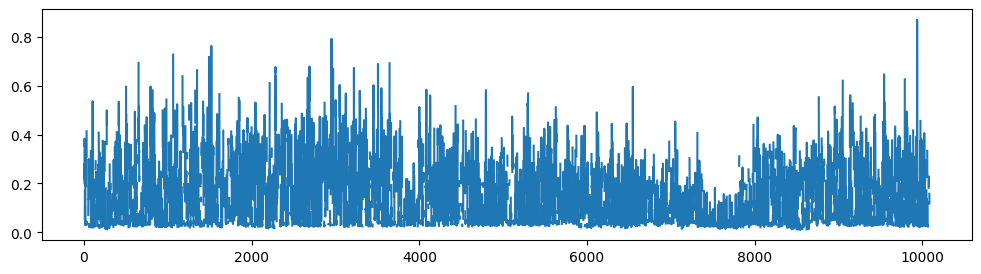

In [4]:
import matplotlib.pyplot as plt
plt.plot(test_nan.Global_intensity)
plt.show()

# **DL models**

## **Train the AutoEncoder**

In [5]:
config_ae = configue.load("./training/config_AE.yaml")
train_loader_ae, val_loader_ae, test_loader_ae = generate_loaders_and_test_nan(config, config_ae,train, val, test, test_nan, test_mask)

total training batch number: 603
total validation batch number: 149
total test batch number: 10063


In [6]:
loss_fn = ORT_MIT_Loss(config_ae["loss_parameter"])
input_dim = train.shape[1] * config_ae["sequence_length"]
## output dimension
output_dim = input_dim
# Hyperparameters
reduction_parameter = config_ae["reduction_parameter"]
hidden_dim1 = int(input_dim * reduction_parameter)
hidden_dim2 = int(hidden_dim1 * reduction_parameter)
# Init model and loss function
model_ae = FullyConnectedAutoencoder(input_dim, hidden_dim1, hidden_dim2, output_dim)
if torch.cuda.is_available():
    model_ae = model_ae.cuda()

<AxesSubplot: xlabel='epochs'>

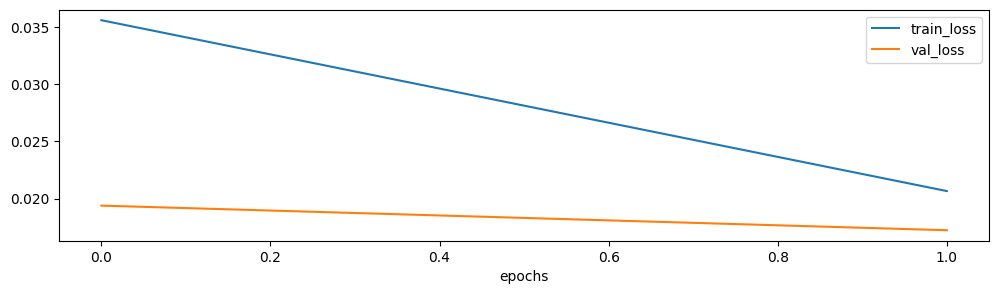

In [7]:
train_loss_list, val_loss_list,model_ae_PATH = train_model(model_ae,loss_fn,config_ae,input_dim,train_loader_ae,val_loader_ae, is_flatten=True, is_TS=False, is_warmed= True)
df = pd.DataFrame({'epochs':[i for i in range(config_ae["epochs"])],'train_loss': train_loss_list,'val_loss': val_loss_list})
df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

## **Train the ConvAE**

In [8]:
config_conv_ae = configue.load("./training/config_convAE.yaml")
train_loader_conv_ae, val_loader_conv_ae, test_loader_conv_ae = generate_loaders_and_test_nan(config, config_conv_ae,train, val, test, test_nan, test_mask)

total training batch number: 1205
total validation batch number: 297
total test batch number: 10051


In [9]:
loss_fn = ORT_MIT_Loss(config_conv_ae["loss_parameter"])
# Parameters
d_input = train.shape[1]
input_dim = train.shape[1] * config_conv_ae["sequence_length"]
# Hyperparameters
reduction_parameter = config_conv_ae["reduction_parameter"]
hidden_dim1 = int(input_dim * reduction_parameter)
hidden_dim2 = int(hidden_dim1 * reduction_parameter)
hidden_dim3 = int(hidden_dim2 * reduction_parameter)
#init model
model_conv_ae = ConvAutoencoder(config_conv_ae["sequence_length"],d_input,hidden_dim1, hidden_dim2,hidden_dim3)
if torch.cuda.is_available():
    model_conv_ae = model_conv_ae.cuda()

<AxesSubplot: xlabel='epochs'>

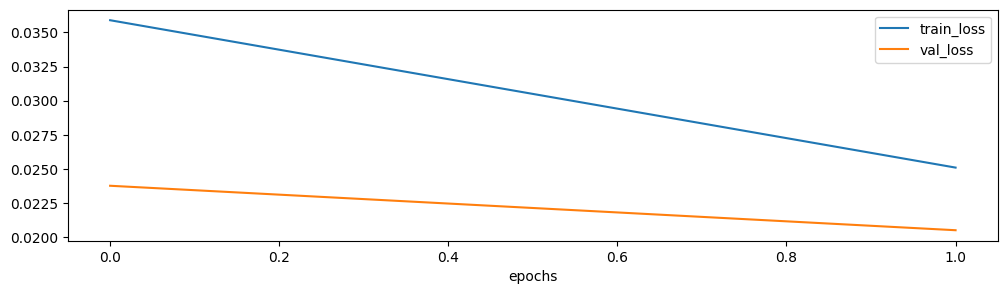

In [10]:
train_loss_list, val_loss_list,model_conv_ae_path = train_model(model_conv_ae,loss_fn,config_conv_ae,input_dim,train_loader_conv_ae,val_loader_conv_ae, is_flatten=False, is_TS=False, is_warmed= False)
df = pd.DataFrame({'epochs':[i for i in range(config_conv_ae["epochs"])],'train_loss': train_loss_list,'val_loss': val_loss_list})
df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

## **Train LSTM AE**

In [11]:
config_lstm_ae = configue.load("./training/config_LSTM_AE.yaml")
train_loader_lstm_ae, val_loader_lstm_ae, test_loader_lstm_ae = generate_loaders_and_test_nan(config, config_lstm_ae,train, val, test, test_nan, test_mask)

total training batch number: 1206
total validation batch number: 298
total test batch number: 10075


In [12]:
loss_fn = ORT_MIT_Loss(config_lstm_ae["loss_parameter"])
# Parameters
d_input = train.shape[1]
#Hyperparameters
reduction_parameter = config_lstm_ae["reduction_parameter"]
embedding_size = int(d_input * reduction_parameter)
#init model and loss
model_ae_lstm = LSTM_Autoencoder(config_lstm_ae["sequence_length"],d_input,embedding_size)
if torch.cuda.is_available():
    model_ae_lstm = model_ae_lstm.cuda()


<AxesSubplot: xlabel='epochs'>

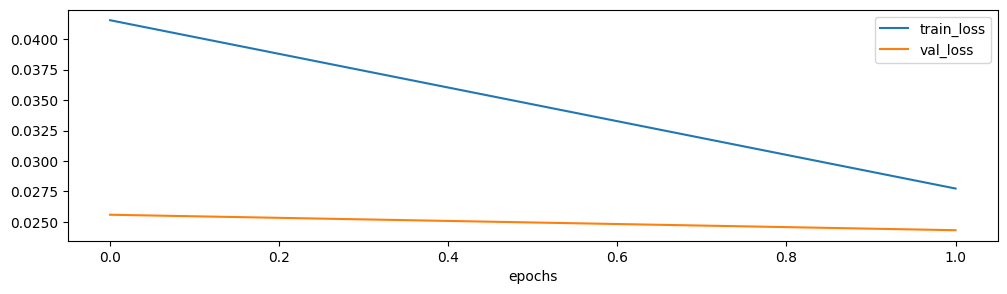

In [13]:
train_loss_list, val_loss_list,model_ae_lstm_path = train_model(model_ae_lstm,loss_fn,config_lstm_ae,d_input,train_loader_lstm_ae,val_loader_lstm_ae, is_flatten=False, is_TS=False, is_warmed= True)
df = pd.DataFrame({'epochs':[i for i in range(config_lstm_ae["epochs"])],'train_loss': train_loss_list,'val_loss': val_loss_list})
df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

## **Train transformer Encoder**

In [14]:
config_ts = configue.load("./training/config_TS.yaml")
train_loader_ts, val_loader_ts, test_loader_ts = generate_loaders_and_test_nan(config, config_ts,train, val, test, test_nan, test_mask)

total training batch number: 602
total validation batch number: 148
total test batch number: 10039


In [15]:
loss_fn = ORT_MIT_Loss(config_ts["loss_parameter"])
# Parameters
d_input = train.shape[1]
TS_model = make_model(d_input=d_input, N=config_ts["N"], d_model=config_ts["d_model"], d_ff=config_ts["d_ff"], h=config_ts["h"], dropout=config_ts["dropout"])
if torch.cuda.is_available():
    TS_model = TS_model.cuda()

<AxesSubplot: xlabel='epochs'>

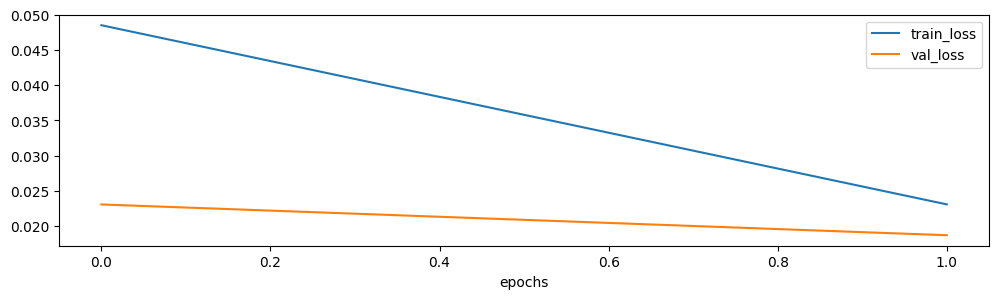

In [16]:
train_loss_list, val_loss_list,TS_model_Path = train_model(TS_model,loss_fn,config_ts,d_input,train_loader_ts,val_loader_ts, is_flatten=False, is_TS=True, is_warmed= False)
df = pd.DataFrame({'epochs':[i for i in range(config_ts["epochs"])],'train_loss': train_loss_list,'val_loss': val_loss_list})
df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

# **Synthesis**

In [17]:
# AE model evaluation
model_ae=load_model(model_ae,model_ae_PATH) #get AE model
test_predicted, test_or = predict(model_ae, test,config_ae["sequence_length"],test_loader_ae, is_flatten = True, is_TS = False )
mse_ae = evaluate_imputation_mse(test_or, test_predicted, test_mask,"AE")
t_test_ae = t_test(test_or, test_predicted, test_mask, "AE")
# AE_conv model eval

model_conv_ae=load_model(model_conv_ae,model_conv_ae_path) #get Conv_AE model
test_predicted, test_or = predict(model_conv_ae, test,config_conv_ae["sequence_length"],test_loader_conv_ae, is_flatten = False, is_TS = False )
mse_conv_ae = evaluate_imputation_mse(test, test_predicted, test_mask,"Conv_autoencoder")
t_test_conv_ae = t_test(test_or, test_predicted, test_mask, "Conv_autoencoder")

# AE_LSTM model eval
model_ae_lstm=load_model(model_ae_lstm,model_ae_lstm_path) #get LSTM_AE model
test_predicted, test_or = predict(model_ae_lstm, test,config_lstm_ae["sequence_length"],test_loader_lstm_ae, is_flatten = False, is_TS = False )
mse_lstm_ae = evaluate_imputation_mse(test, test_predicted, test_mask,"LSTM_autoencoder")
t_test_lstm_ae = t_test(test_or, test_predicted, test_mask, "LSTM_autoencoder")

# transformer model eval
info = torch.load(TS_model_Path)["config_model"]
model_TS = make_model(d_input=info['d_input'], N=info['N'], d_model=info['d_model'], d_ff=info['d_ff'], h=info['h'], dropout=info['dropout'])
model_TS=load_model(model_TS,TS_model_Path) #get LSTM_AE model
if torch.cuda.is_available():
    model_TS = model_TS.cuda()
test_predicted, test_or = predict(model_TS, test,config_ts["sequence_length"],test_loader_ts, is_flatten = False, is_TS = True )
mse_ts = evaluate_imputation_mse(test, test_predicted, test_mask,"Transformer_encoder")
t_test_ts  = t_test(test_or, test_predicted, test_mask, "Transformer_encoder")

In [ ]:
evaluations, tests_classique = evaluate_set(config["class_methods"],test,test_nan,test_mask)
evaluations=pd.concat([evaluations,mse_ts,mse_lstm_ae,mse_ae,mse_conv_ae],axis=0)
evaluations = evaluations.sort_values(by=["mse"])
evaluations.reset_index(drop=True, inplace=True)
evaluations

--------------------
For  mean  the mse per column is: 
Global_active_power      0.023930
Global_reactive_power    0.014877
Voltage                  0.014104
Global_intensity         0.022556
Sub_metering_1           0.004737
Sub_metering_2           0.014978
Sub_metering_3           0.156451
dtype: float64
mse_mean  0.03594758651598736
--------------------
For  median  the mse per column is: 
Global_active_power      0.025356
Global_reactive_power    0.015654
Voltage                  0.014113
Global_intensity         0.024864
Sub_metering_1           0.005269
Sub_metering_2           0.016011
Sub_metering_3           0.221229
dtype: float64
mse_mean  0.04607086389152119
--------------------
For  mode  the mse per column is: 
Global_active_power      0.045514
Global_reactive_power    0.025967
Voltage                  0.014491
Global_intensity         0.044729
Sub_metering_1           0.005269
Sub_metering_2           0.016419
Sub_metering_3           0.273096
dtype: float64
mse_mean  0

,method,mse,var
0,AE,0.004090,0.000036
1,linear_interpolation,0.018414,0.000681
2,mice,0.019714,0.000893
3,NOCB,0.032284,0.002186
4,LOCF,0.032852,0.002281
5,spline_interpolation,0.035360,0.002865
6,mean,0.035948,0.002863
7,knn,0.036831,0.003173
8,median,0.046071,0.006012
9,mode,0.060784,0.008995


In [ ]:
count_params = [count_parameters(model) for model in [TS_model,model_ae_lstm,model_ae,model_conv_ae]]
column_model_complexity = pd.DataFrame(count_params, columns=["model_complexity"], index=["Transformer_encoder","LSTM_autoencoder","Autoencoder","Conv_autoencoder"]) 
column_model_complexity.sort_values(by=["model_complexity"])

,model_complexity
LSTM_autoencoder,719
Autoencoder,35658
Transformer_encoder,251335
Conv_autoencoder,631508


Text(0.5, 1.0, 'MSE evaluation of all approaches in test set')

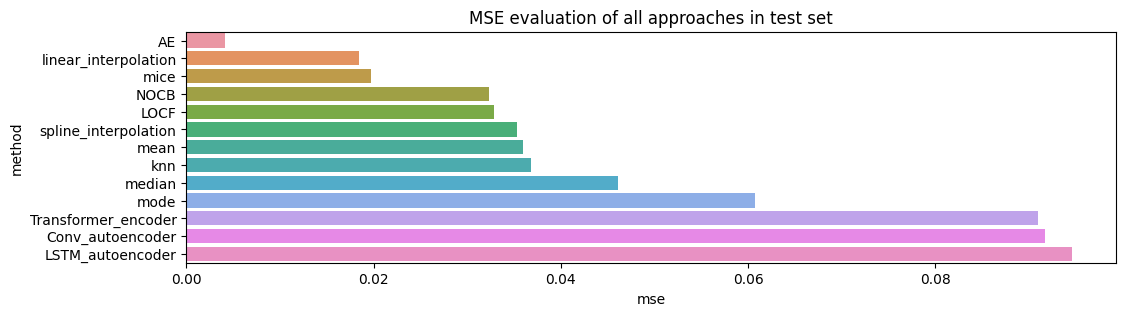

In [ ]:
sns.barplot(x='mse',y='method',data=evaluations)
plt.title('MSE evaluation of all approaches in test set')

In [ ]:
tests_classique=pd.concat([tests_classique,t_test_ae,t_test_lstm_ae,t_test_ts,t_test_conv_ae],axis=0)
tests_classique

,method,column,p-value,same_distribution
0,mean,Global_active_power,0.889896,False
1,mean,Global_reactive_power,0.548351,False
2,mean,Voltage,0.947904,False
3,mean,Global_intensity,0.385762,False
4,mean,Sub_metering_1,0.618196,False
...,...,...,...,...
2,Conv_autoencoder,Voltage,0.978429,False
3,Conv_autoencoder,Global_intensity,0.692393,False
4,Conv_autoencoder,Sub_metering_1,0.857338,False
5,Conv_autoencoder,Sub_metering_2,0.572035,False


In [ ]:
tests_classique[tests_classique.method == "Conv_autoencoder"]

,method,column,p-value,same_distribution
0,Conv_autoencoder,Global_active_power,0.959512,False
1,Conv_autoencoder,Global_reactive_power,0.042954,True
2,Conv_autoencoder,Voltage,0.978429,False
3,Conv_autoencoder,Global_intensity,0.692393,False
4,Conv_autoencoder,Sub_metering_1,0.857338,False
5,Conv_autoencoder,Sub_metering_2,0.572035,False
6,Conv_autoencoder,Sub_metering_3,0.665714,False
0,Conv_autoencoder,Global_active_power,0.959512,False
1,Conv_autoencoder,Global_reactive_power,0.042954,True
2,Conv_autoencoder,Voltage,0.978429,False


In [ ]:
tests_classique["same_distribution"] = tests_classique["same_distribution"].astype(int)
tests_classique.drop(['column','p-value'],axis = 1,inplace=True)
tests_classique = tests_classique.groupby(['method'],as_index=False).sum()
tests_classique

,method,same_distribution
0,AE,0
1,Conv_autoencoder,2
2,LOCF,0
3,LSTM_autoencoder,2
4,NOCB,0
5,Transformer_encoder,0
6,knn,3
7,linear_interpolation,0
8,mean,0
9,median,6


In [ ]:
tests_classique = tests_classique.sort_values(by=["same_distribution"],ascending=False)

Text(0.5, 1.0, 'total number of features with same distribution after imputation')

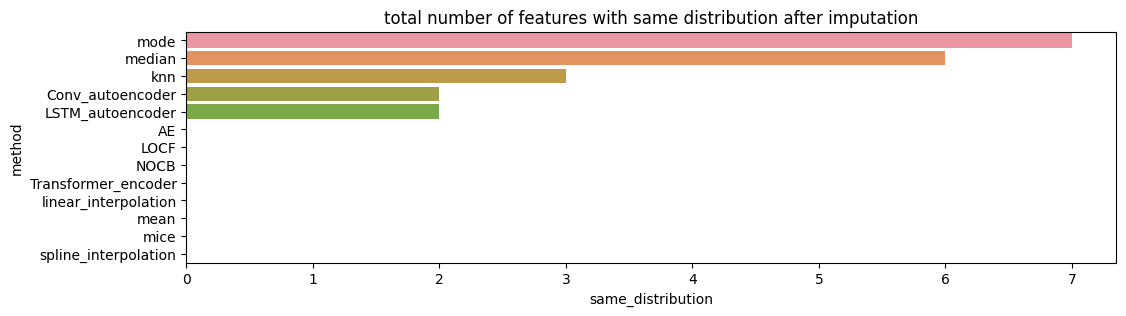

In [ ]:
sns.barplot(x='same_distribution',y='method',data=tests_classique)
plt.title("total number of features with same distribution after imputation")